# Pulse Height Analysis - ADC Histograms Study

Here the I use the ROC's ADC output directly.
The practical reason for this are the following:
* The ADC --> Charge calibration is not always pretty
* The calibration may change more frequently then the ADC parameters
* More "raw" data

"Table of contents":
* some subroutines and data import
* plots as a function of fill ID
    + some general functionals of the histograms
    + integral and "ADC charge" ratios using several different strategies


In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
// disable autoscroll

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

from scipy.optimize import curve_fit
import ROOT
import os, re, math
import matplotlib.pyplot as plt
import numpy as np


from matplotlib import animation
from IPython.display import HTML

Welcome to JupyROOT 6.09/01


## Some important subroutines follow
+import of the data

In [3]:
def load_root_files():

    file_name_list      = [ f for f in os.listdir("pulse_height_data") if os.path.isfile("pulse_height_data/" + f) and f[-5:]==".root"]

    fill_ID_and_Ch_and_ROC_and_hist_name_to_hist= {}

    for file_name in file_name_list:

        fill_ID             = int(re.findall(r'\d+', file_name)[0])
        fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID]= {}

        file_    = ROOT.TFile("pulse_height_data/" + file_name, "READ")

        list_of_objects     = sorted([RootKey.GetName() for RootKey in file_.GetListOfKeys()])
            
        for directory_name in list_of_objects:

            Ch, Roc = [int(_) for _ in re.findall(r'\d+', directory_name )]
            
            if file_.Get(directory_name + "/h_clusterSize").Integral()<10000:
                continue

            try:
                fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID][Ch][Roc]  = {}
            except:
                fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID][Ch]       = {}
                fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID][Ch][Roc]  = {}

            directory       = file_.Get(directory_name)
            list_of_hists   = [RootKey.GetName() for RootKey in directory.GetListOfKeys()]

            for hist_name in list_of_hists:
                if hist_name != "h_spatialChargeDistribution":
                    fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID][Ch][Roc][hist_name] = file_.Get(directory_name + "/" + hist_name).Clone()
                    fill_ID_and_Ch_and_ROC_and_hist_name_to_hist[fill_ID][Ch][Roc][hist_name].SetDirectory(0)  
                    
        file_.Close()
        
    return fill_ID_and_Ch_and_ROC_and_hist_name_to_hist

In [4]:
def fittie(X, Y,k):

    if len(X)!=len(Y):
        print "Error"
        return [[],[]]
    else:
        retX = []
        retY = []
        for i1 in range(0,len(X)-k):
            sX = []
            sY = []
            for i2 in range(k):
                sX+=[X[i1+i2]]
                sY+=[Y[i1+i2]]
            
            z = np.polyfit(sX, sY, 1)
            
            retX += [X[i1]]
            retY += [z[0]]
            
        return [retX,retY]
    
def median_filter(v,k):
    ret_v = v[:]
    
    for i in range(k, len(v)-k):
        ret_v[i] = np.median(v[i-k:i+k])  
    
    
    return ret_v
        
    
def x_values_of_points_at_p_percent_of_max_on_the_two_sides_of_max(v, p):
    
    maximum = max(v)
    if sum([ 1.0 for v_ in v if v_ == maximum])!=1.0:
        return [-1,-1]
    else:
        maximum_location = v.index(maximum)
        left = v[:maximum_location]
        right= v[maximum_location:]
        
        left_D = [abs(maximum*p-x) for x in left]
        right_D= [abs(maximum*p-x) for x in right]
        
        i1 = left_D.index(min(left_D))
        i2 = right_D.index(min(right_D)) + len(left_D)
        
        return [i1, i2]
            
            
def gaussian(x,a,m,sigma):
    return a*np.exp(-(x-m)**2/(2*sigma**2))/sigma

def lognormal(x,a,m,sigma):
    return a*np.exp(-(np.log(x)-m)**2/(2*sigma**2))/x/sigma

In [5]:
"""
Load histograms only once
"""
hist_dict = load_root_files()

# Here I plot some properties of the datasets as a function of fill ID



## Some functionals of the ADC distribution

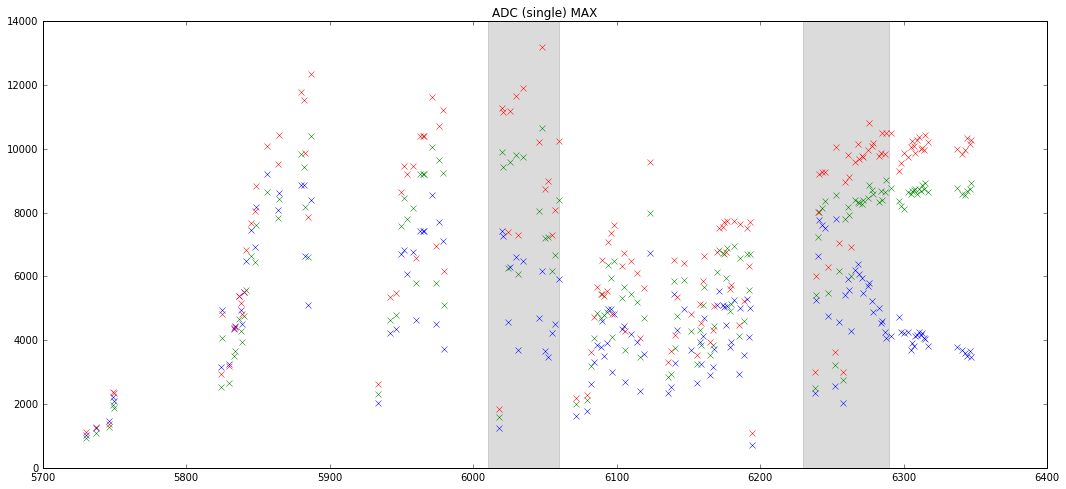

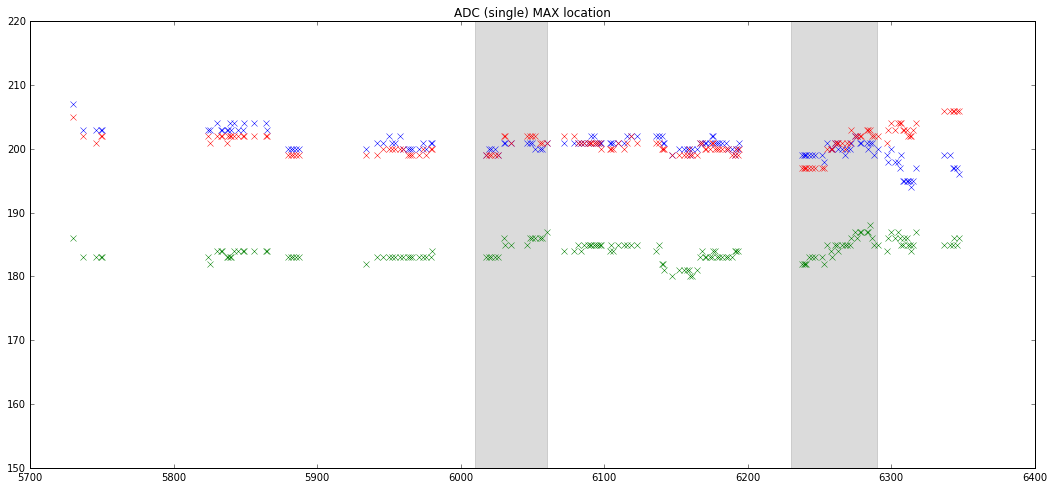

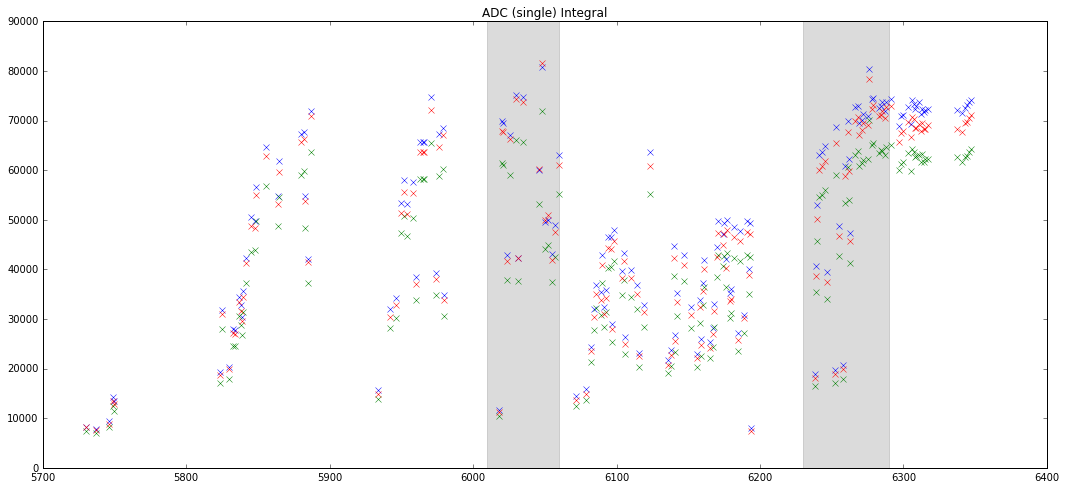

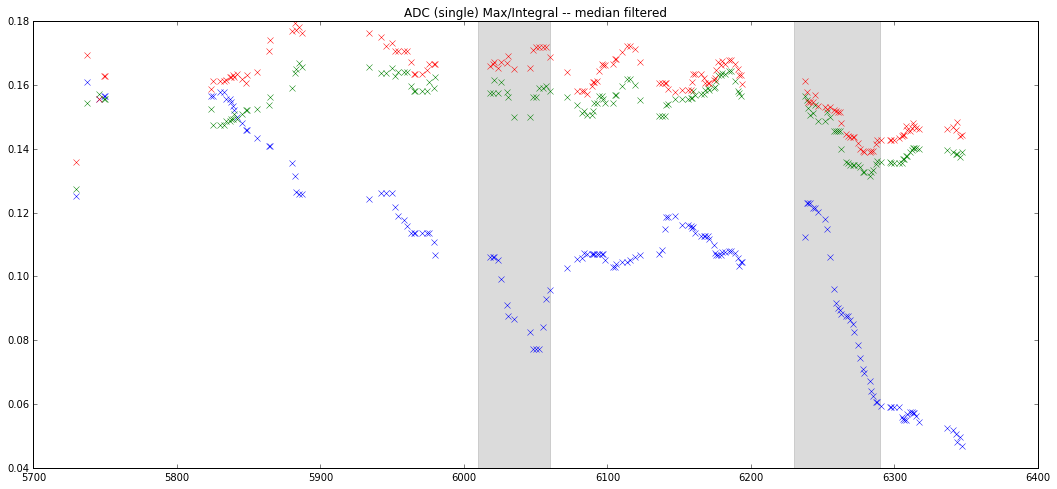

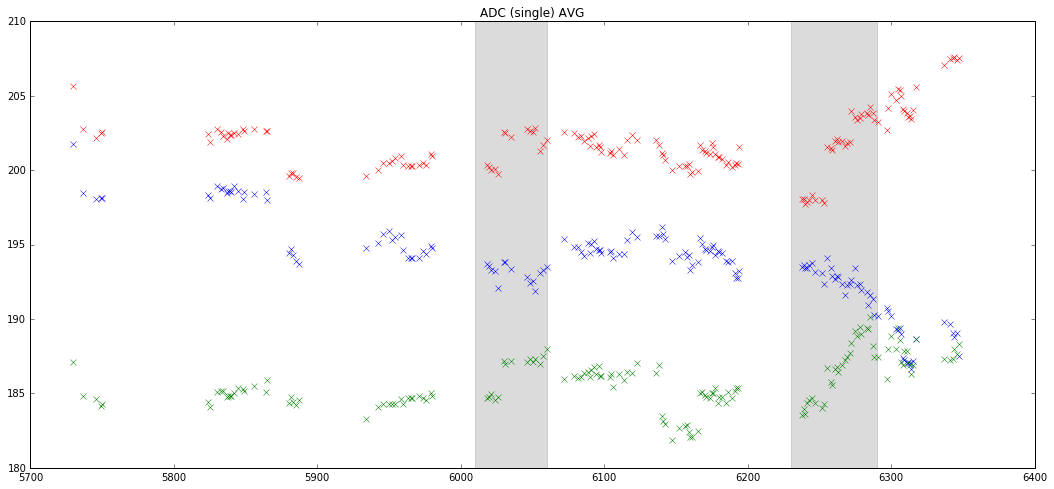

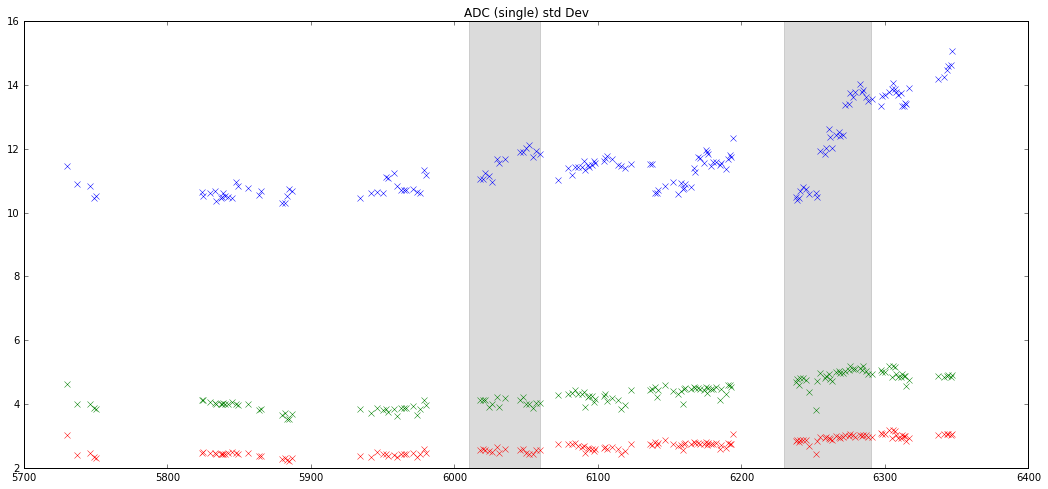

[2, 0] has been plotted using 160 points
[2, 1] has been plotted using 159 points
[2, 2] has been plotted using 160 points


In [6]:
"""
ADC maximum and maximum location, integral, max/integral, average and standard deviation
"""

Ch_Roc_pairs = [[2, 0], [2, 1], [2, 2],] 


n_plot_to_fill_IDs                  = []
n_plot_to_ADC_maximum               = []
n_plot_to_ADC_maximum_location      = []
n_plot_to_ADC_integral              = []
n_plot_to_ADC_average               = []
n_plot_to_ADC_std_dev               = []



for pair in Ch_Roc_pairs:

    n_plot_to_fill_IDs                += [[]]
    n_plot_to_ADC_maximum             += [[]]
    n_plot_to_ADC_maximum_location    += [[]]
    n_plot_to_ADC_integral            += [[]]
    n_plot_to_ADC_average             += [[]]
    n_plot_to_ADC_std_dev             += [[]]
    

    fill_IDs = sorted(hist_dict.keys())
    for fill_ID in fill_IDs:
        if pair[0] in hist_dict[fill_ID].keys():
            if pair[1] in hist_dict[fill_ID][pair[0]].keys():
                n_plot_to_fill_IDs[-1] += [fill_ID]

                hist = hist_dict[fill_ID][pair[0]][pair[1]]["h_singlePulse_ADC"].Clone()
                
        
                n_plot_to_ADC_maximum[-1] += [hist.GetMaximum()]
                n_plot_to_ADC_maximum_location[-1]    += [hist.GetBinCenter(hist.GetMaximumBin())]
                n_plot_to_ADC_integral[-1]            += [hist.Integral()]
                n_plot_to_ADC_average[-1]             += [hist.GetMean()]
                n_plot_to_ADC_std_dev[-1]             += [hist.GetStdDev()]
                
                
plt.figure(11,figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    print pair, "has been plotted using", len(n_plot_to_fill_IDs[i]), "points"
    
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_ADC_maximum[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_M" )
    
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.title("ADC (single) MAX")
    
plt.figure(12, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    plt.plot(n_plot_to_fill_IDs[i], n_plot_to_ADC_maximum_location[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_ML" )
    
    plt.axvspan(6010, 6060,  alpha=0.1, color='grey')
    plt.axvspan(6230, 6290,  alpha=0.1, color='grey')
    
    plt.title("ADC (single) MAX location")
    
    plt.ylim(150,220)
    
plt.figure(13, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    plt.plot(n_plot_to_fill_IDs[i], n_plot_to_ADC_integral[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_ML_int" )
    
    plt.axvspan(6010, 6060,  alpha=0.1, color='grey')
    plt.axvspan(6230, 6290,  alpha=0.1, color='grey')
    
    plt.title("ADC (single) Integral")
    
    #plt.ylim(150,220)
    
plt.figure(14, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    Dy = []
    for j in range(len(n_plot_to_fill_IDs[i])):
        Dy+= [n_plot_to_ADC_maximum[i][j]/n_plot_to_ADC_integral[i][j]]
    
    Dy=median_filter(Dy,3)
    plt.plot(n_plot_to_fill_IDs[i], Dy,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_ML_mxPint" )
    
    plt.axvspan(6010, 6060,  alpha=0.1, color='grey')
    plt.axvspan(6230, 6290,  alpha=0.1, color='grey')
    
    plt.title("ADC (single) Max/Integral -- median filtered")
    
    #plt.ylim(150,220)
    
plt.figure(15, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    plt.plot(n_plot_to_fill_IDs[i], n_plot_to_ADC_average[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_ML_avg" )
    
    plt.axvspan(6010, 6060,  alpha=0.1, color='grey')
    plt.axvspan(6230, 6290,  alpha=0.1, color='grey')
    
    plt.title("ADC (single) AVG")
    
    #plt.ylim(150,220)
    
plt.figure(16, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    plt.plot(n_plot_to_fill_IDs[i], n_plot_to_ADC_std_dev[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_ML_stddev" )
    
    plt.axvspan(6010, 6060,  alpha=0.1, color='grey')
    plt.axvspan(6230, 6290,  alpha=0.1, color='grey')
    
    plt.title("ADC (single) std Dev")
    
    #plt.ylim(150,220)

## Left / Right Integral Ratios in Single Pixel Cluster ADC Spectra

The ROCs that are farther from the IP have a long tail due to the delta electrons. These are low energy particles that are no longer MIPs, hence they are not sensitive to the developing inefficiency (am I right??).

While clearly there are several parallel effects are at work, this suggests that it is worth to examine the shape changes of the ROC0 spectra.

Here I examine the ratio
$$R=\frac{\int_0^a f dx}{\int_a^{max} f dx}$$
for some $a$ divider value, that should be characteristic of the spectra.

* **$a=$ maximum location**: This does not yield a good result, probably because the spectra cuts sharply above the max. 
* **$a=$ maximum location-10**: This is much better, shows much less noise, but seems to only work for `ROC = 0`.
* **$a=$180**: For Ch08ROC0 this is too low for example.
* **$a=$ int(mean)-10**: This is also nice.
* **$a$**: Derivate the histogram, $a$ is the point in the middle where the derivative is closest to 1: Really noisy
:/

*Could this be an effect of the spectrum getting just wider?* 
` maximum location-10` --> maximum location-$\alpha\cdot$StdDev
* **Percent of full height def**: Not so bad, but not better than the simple solutions. 

In an attempt to give a more natural separation of the areas here I tried another two methods:
* Fitting a Gaussian/lognormal on the peak
* Using the integral ratio between ROC2 and ROC0

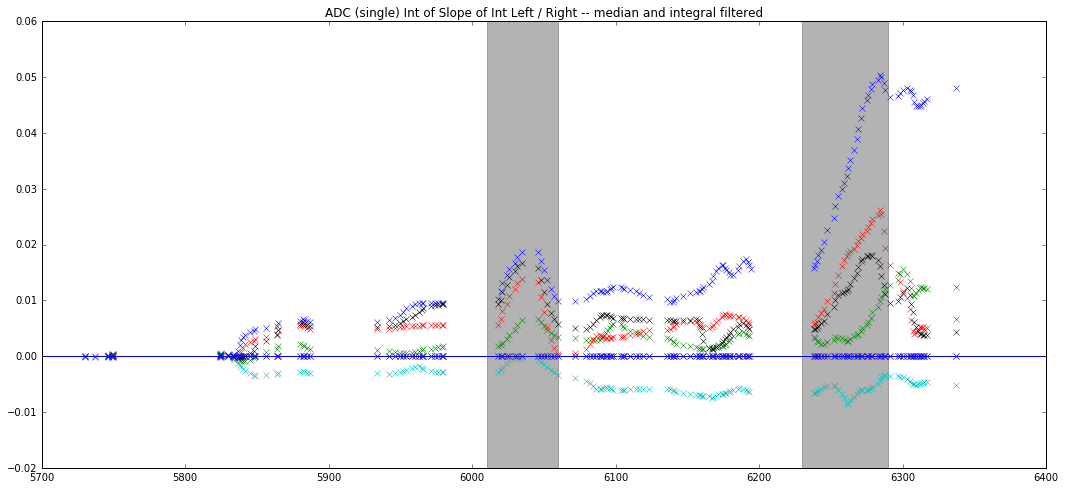

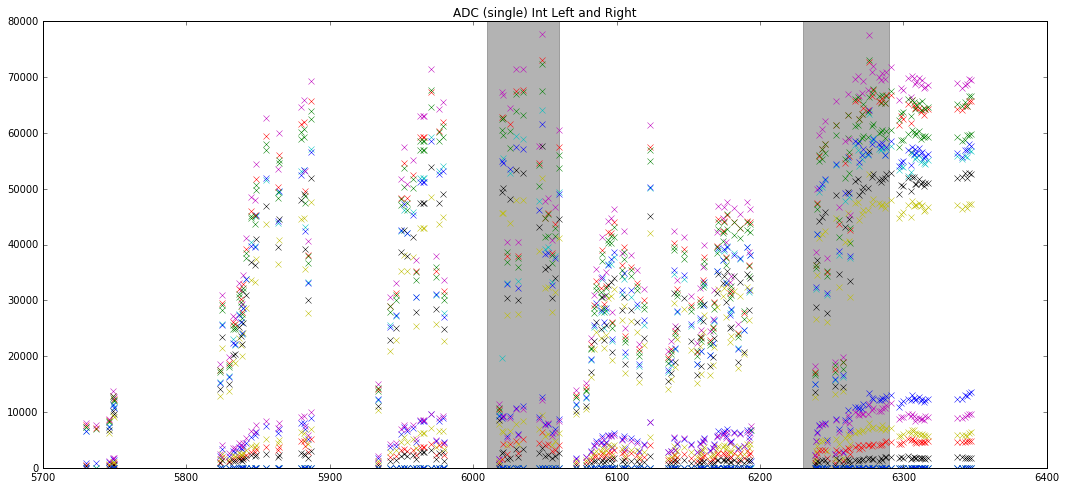

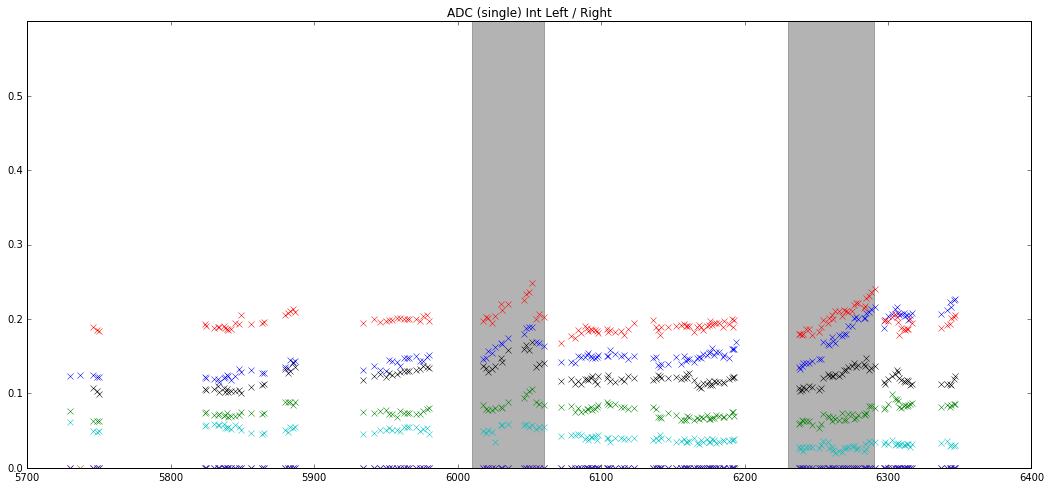

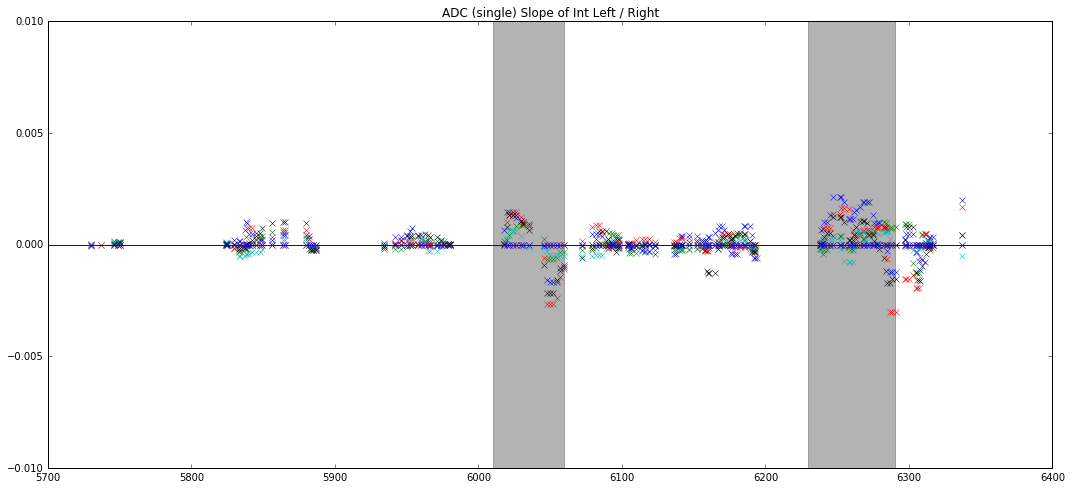

[2, 0] has been plotted using 160 points
[4, 0] has been plotted using 158 points
[5, 0] has been plotted using 157 points
[8, 0] has been plotted using 158 points
[10, 0] has been plotted using 159 points
[11, 0] has been plotted using 159 points
[13, 0] has been plotted using 157 points
[14, 0] has been plotted using 158 points


In [7]:
"""
Check the integral of the ADC spectra left and right from a div point.
FOR SINGLE CLUSTER!
"""

Ch_Roc_pairs = [[2, 0], [4, 0], [5, 0], [8, 0], [10, 0], [11, 0], [13, 0], [14, 0],] 
#Ch_Roc_pairs = [[2, 1], [4, 1], [5, 1], [8, 1], [10, 1], [11, 1], [13, 1], [14, 1],] 
#Ch_Roc_pairs = [[2, 2], [4, 2], [5, 2], [8, 2], [10, 2], [11, 2], [13, 2], [14, 2],]

n_plot_to_fill_IDs                  = []
n_plot_to_ADC_integral_left         = []
n_plot_to_ADC_integral_right        = []
n_plot_to_ADC_integral_ratio        = []



for pair in Ch_Roc_pairs:

    n_plot_to_fill_IDs                += [[]]
    n_plot_to_ADC_integral_left       += [[]]
    n_plot_to_ADC_integral_right      += [[]]
    n_plot_to_ADC_integral_ratio      += [[]]
    

    fill_IDs = sorted(hist_dict.keys())
    for fill_ID in fill_IDs:
        if pair[0] in hist_dict[fill_ID].keys():
            if pair[1] in hist_dict[fill_ID][pair[0]].keys():
                n_plot_to_fill_IDs[-1] += [fill_ID]

                hist = hist_dict[fill_ID][pair[0]][pair[1]]["h_singlePulse_ADC"].Clone()
   ########################################################################################################
   ########      CHOSE YOUR POISON HERE     ###############################################################
   ########################################################################################################
                #div_point =hist.GetMaximumBin()-10
                div_point = int(hist.GetMean())-10
                #div_point = int(hist.GetMean() - hist.GetStdDev())
                #div_point = 180
                if False:
                    hist_list = []
                    for i in range(hist.GetNbinsX()):
                        hist_list += [hist.GetBinContent(i)]
                    
                    D = []
                    for i in range(1, len(hist_list)-1):
                        D += [abs(5-(hist_list[i+1] - hist_list[i-1])/2)]
                        
                    D = median_filter(D, 5)
                    div_point = D.index(min(D[170:200]))
                    
                if False:
                    hist_list = []
                    for i in range(hist.GetNbinsX()):
                        hist_list += [hist.GetBinContent(i)]  
                    hist_list = np.convolve(hist_list, [1,1,1], 'same')
                    a,b = x_values_of_points_at_p_percent_of_max_on_the_two_sides_of_max(hist_list, .9)
                    div_point = int((a+b)/2-10)
                
                if False:
                    hist_list = []
                    for i in range(hist.GetNbinsX()):
                        hist_list += [hist.GetBinContent(i)]  
                    hist_list = list(np.convolve(hist_list, [1,1,1], 'same'))
                    div_point = hist_list.index(max(hist_list))-10
   ########################################################################################################
   ########################################################################################################
   ########################################################################################################
                left = float(hist.Integral(1, div_point-1))
                right= float(hist.Integral(div_point+1, hist.GetNbinsX()))
                
                n_plot_to_ADC_integral_left[-1]       += [left]
                n_plot_to_ADC_integral_right[-1]      += [right]
                
                try:
                    n_plot_to_ADC_integral_ratio[-1]      += [left/right]
                except:
                    n_plot_to_ADC_integral_ratio[-1]      += [0]
                
                
plt.figure(21,figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    print pair, "has been plotted using", len(n_plot_to_fill_IDs[i]), "points"
    
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_ADC_integral_left[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_L" )
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_ADC_integral_right[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_R" )
    
    plt.axvspan(6010, 6060,  alpha=0.1, color='grey')
    plt.axvspan(6230, 6290,  alpha=0.1, color='grey')
    
    plt.title("ADC (single) Int Left and Right")
    
plt.figure(22, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_ADC_integral_ratio[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_LRR" )
    
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.ylim(0,.6)
    
    plt.title("ADC (single) Int Left / Right")
    
    
#create a derivative of the ratios
plt.figure(23, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):
    Dx,Dy = fittie(n_plot_to_fill_IDs[i], n_plot_to_ADC_integral_ratio[i],5)
        
    Dy = median_filter(Dy, 3)
    plt.plot(Dx,Dy,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_LRRD" )
     
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.axhline(0)

    plt.ylim(-0.01,.01)
    
    plt.title("ADC (single) Slope of Int Left / Right")
    
    
plt.figure(25, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):
    Dx,Dy = fittie(n_plot_to_fill_IDs[i], n_plot_to_ADC_integral_ratio[i],5)
        
    Dy = median_filter(Dy, 3)
    
    for i in range(1,len(Dy)):
        Dy[i]+=Dy[i-1]
    
    plt.plot(Dx,Dy,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_LRRD" )
     
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.axhline(0)

    plt.ylim(-0.02,.06)
    
    plt.title("ADC (single) Int of Slope of Int Left / Right -- median and integral filtered")

## Left / Right Integral Ratios in Sum Pixel Cluster ADC Spectra

Same info as before, not the same results though!

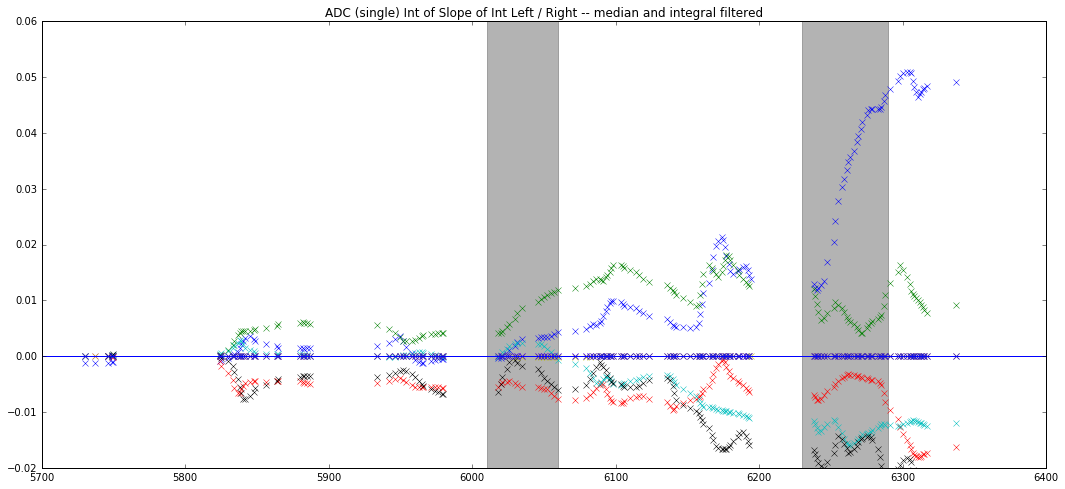

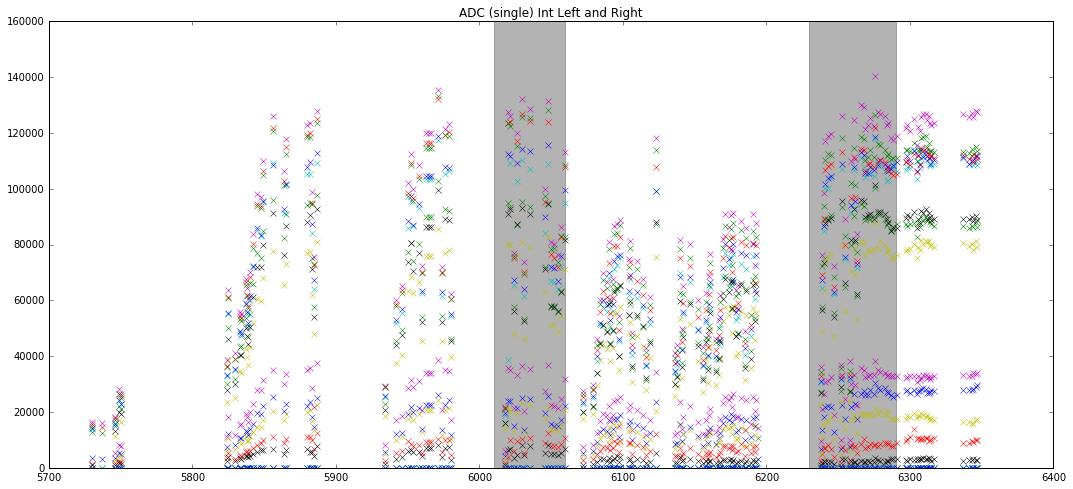

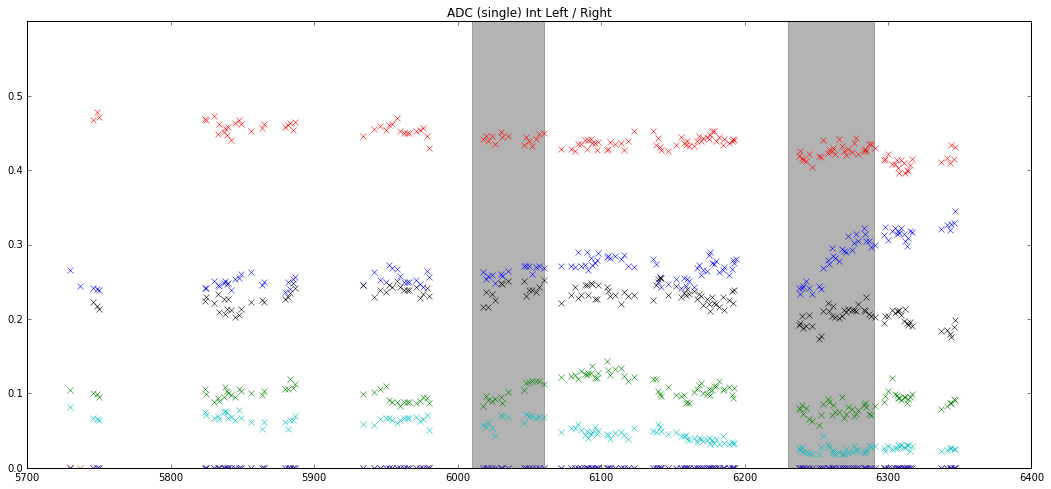

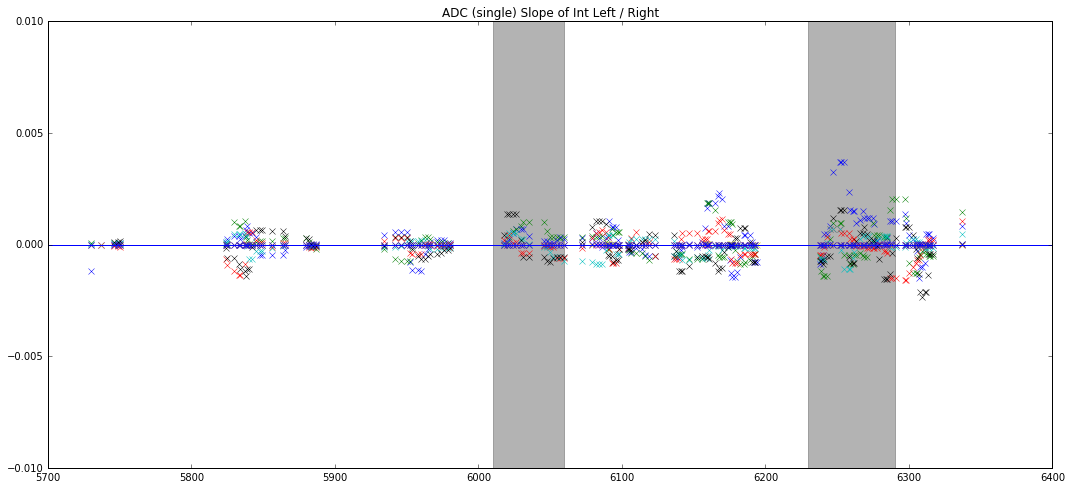

[2, 0] has been plotted using 160 points
[4, 0] has been plotted using 158 points
[5, 0] has been plotted using 157 points
[8, 0] has been plotted using 158 points
[10, 0] has been plotted using 159 points
[11, 0] has been plotted using 159 points
[13, 0] has been plotted using 157 points
[14, 0] has been plotted using 158 points


In [8]:
"""
Check the integral of the ADC spectra left and right from a div point. h_allPixelPulse_ADC
FOR ALL PIXELS
"""

Ch_Roc_pairs = [[2, 0], [4, 0], [5, 0], [8, 0], [10, 0], [11, 0], [13, 0], [14, 0],] 
#Ch_Roc_pairs = [[2, 1], [4, 1], [5, 1], [8, 1], [10, 1], [11, 1], [13, 1], [14, 1],] 
#Ch_Roc_pairs = [[2, 2], [4, 2], [5, 2], [8, 2], [10, 2], [11, 2], [13, 2], [14, 2],]

n_plot_to_fill_IDs                  = []
n_plot_to_ADC_integral_left         = []
n_plot_to_ADC_integral_right        = []
n_plot_to_ADC_integral_ratio        = []



for pair in Ch_Roc_pairs:

    n_plot_to_fill_IDs                += [[]]
    n_plot_to_ADC_integral_left       += [[]]
    n_plot_to_ADC_integral_right      += [[]]
    n_plot_to_ADC_integral_ratio      += [[]]
    

    fill_IDs = sorted(hist_dict.keys())
    for fill_ID in fill_IDs:
        if pair[0] in hist_dict[fill_ID].keys():
            if pair[1] in hist_dict[fill_ID][pair[0]].keys():
                n_plot_to_fill_IDs[-1] += [fill_ID]

                hist = hist_dict[fill_ID][pair[0]][pair[1]]["h_allPixelPulse_ADC"].Clone()
   ########################################################################################################
   ########      CHOSE YOUR POISON HERE     ###############################################################
   ########################################################################################################
                #div_point =hist.GetMaximumBin()-10
                div_point = int(hist.GetMean())-10
                #div_point = int(hist.GetMean()- 0.5*hist.GetStdDev())
                #div_point = 180
                if False:
                    hist_list = []
                    for i in range(hist.GetNbinsX()):
                        hist_list += [hist.GetBinContent(i)]
                    
                    D = []
                    for i in range(1, len(hist_list)-1):
                        D += [abs(5-(hist_list[i+1] - hist_list[i-1])/2)]
                        
                    D = median_filter(D, 5)
                    div_point = D.index(min(D[170:200]))
                    
                if False:
                    hist_list = []
                    for i in range(hist.GetNbinsX()):
                        hist_list += [hist.GetBinContent(i)]  
                    hist_list = np.convolve(hist_list, [1,1,1], 'same')
                    a,b = x_values_of_points_at_p_percent_of_max_on_the_two_sides_of_max(hist_list, .9)
                    div_point = int((a+b)/2-10)
                
                if False:
                    hist_list = []
                    for i in range(hist.GetNbinsX()):
                        hist_list += [hist.GetBinContent(i)]  
                    hist_list = list(np.convolve(hist_list, [1,1,1], 'same'))
                    div_point = hist_list.index(max(hist_list))-10
   ########################################################################################################
   ########################################################################################################
   ########################################################################################################
                left = float(hist.Integral(1, div_point-1))
                right= float(hist.Integral(div_point+1, hist.GetNbinsX()))
                
                n_plot_to_ADC_integral_left[-1]       += [left]
                n_plot_to_ADC_integral_right[-1]      += [right]
                
                try:
                    n_plot_to_ADC_integral_ratio[-1]      += [left/right]
                except:
                    n_plot_to_ADC_integral_ratio[-1]      += [0]
                
                
plt.figure(21,figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    print pair, "has been plotted using", len(n_plot_to_fill_IDs[i]), "points"
    
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_ADC_integral_left[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_L" )
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_ADC_integral_right[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_R" )
    
    plt.axvspan(6010, 6060,  alpha=0.1, color='grey')
    plt.axvspan(6230, 6290,  alpha=0.1, color='grey')
    
    plt.title("ADC (single) Int Left and Right")
    
plt.figure(22, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_ADC_integral_ratio[i],"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_LRR" )
    
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.ylim(0,.6)
    
    plt.title("ADC (single) Int Left / Right")
    
    
#create a derivative of the ratios
plt.figure(23, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):
    Dx,Dy = fittie(n_plot_to_fill_IDs[i], n_plot_to_ADC_integral_ratio[i],5)
        
    Dy = median_filter(Dy, 3)
    plt.plot(Dx,Dy,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_LRRD" )
     
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.axhline(0)

    plt.ylim(-0.01,.01)
    
    plt.title("ADC (single) Slope of Int Left / Right")
    
    
plt.figure(25, figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):
    Dx,Dy = fittie(n_plot_to_fill_IDs[i], n_plot_to_ADC_integral_ratio[i],5)
        
    Dy = median_filter(Dy, 3)
    
    for i in range(1,len(Dy)):
        Dy[i]+=Dy[i-1]
    
    plt.plot(Dx,Dy,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_LRRD" )
     
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    plt.axhline(0)

    plt.ylim(-0.02,.06)
    
    plt.title("ADC (single) Int of Slope of Int Left / Right -- median and integral filtered")

## Left / Right Integral Ratios in Single Pixel Cluster ADC Spectra -- Gaussian Method

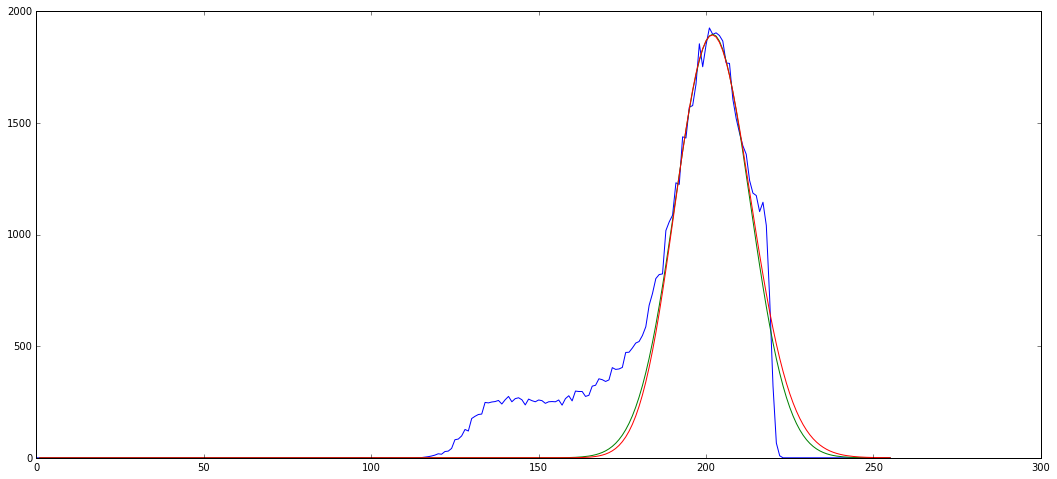

0.777998246977 256 [  2.11674651e+04   2.01985170e+02   1.11557301e+01]


In [9]:
"""
Test Gaussian / lognormal fitting goodness -- not too good :/
"""

hist = hist_dict[6060][17][0]["h_singlePulse_ADC"].Clone()
div_point =hist.GetMaximumBin()-10
#Fit here
fit_list = []
upper_lim = min(hist.GetNbinsX(), hist.GetMaximumBin() + 10)
for i in range(div_point, upper_lim):
    fit_list += [hist.GetBinContent(i)]
hist_list = []
for i in range(0, hist.GetNbinsX()):
    hist_list += [hist.GetBinContent(i)]
                    
popt,pcov = curve_fit(gaussian,
                                      range(div_point, upper_lim),
                                      fit_list,
                                      p0=[ hist.GetMaximum(), hist.GetMaximumBin(), 5]
                                     )

popt2,pcov = curve_fit(lognormal,
                                      range(div_point, upper_lim),
                                      fit_list,
                                      p0=[ hist.GetMaximum()*hist.GetMaximumBin(), np.log(hist.GetMaximumBin()), 0.2]
                                     )

plt.figure(figsize=(18, 8))
plt.plot(range(0, hist.GetNbinsX()), hist_list)
plt.plot(range(1, hist.GetNbinsX()), gaussian(range(1, hist.GetNbinsX()), *popt))
plt.plot(range(1, hist.GetNbinsX()), lognormal(range(1, hist.GetNbinsX()), *popt2))

#print "knsdlkn", pcov

print popt[0]*2.5/hist.Integral(), hist.GetNbinsX(), popt


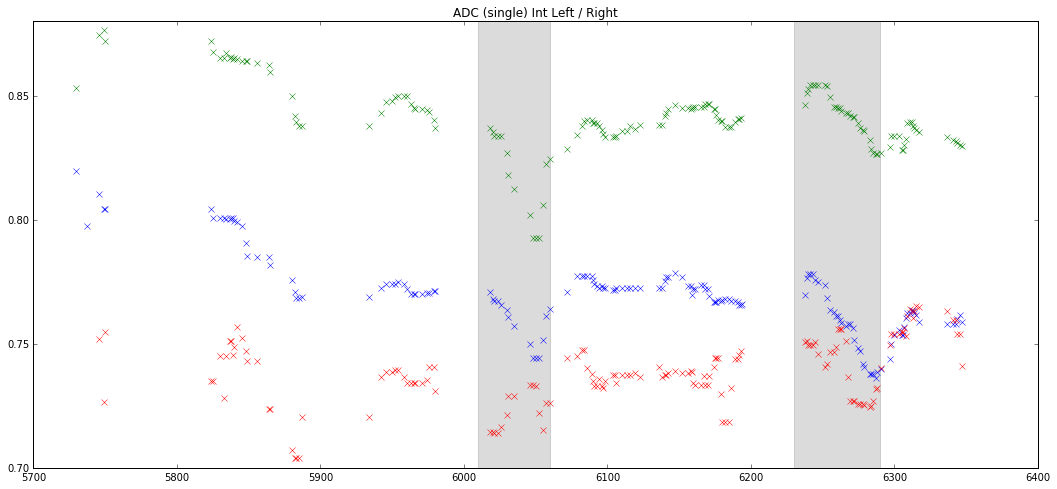

In [10]:
"""
To more naturally segment the spectra:
fit a Gaissian into the peak, take the ratio of that and the whole spectra

I fit till the div_point
"""

Ch_Roc_pairs = [[2, 0], [4, 0], [5, 0],]# [8, 0], [10, 0], [11, 0], [13, 0], [14, 0],] 
#Ch_Roc_pairs = [[2, 1], [4, 1], [5, 1], [8, 1], [10, 1], [11, 1], [13, 1], [14, 1],] 
#Ch_Roc_pairs = [[2, 2], [4, 2], [5, 2], [8, 2], [10, 2], [11, 2], [13, 2], [14, 2],]

n_plot_to_fill_IDs                  = []
n_plot_to_ADC_integral_ratio        = []



for pair in Ch_Roc_pairs:

    n_plot_to_fill_IDs                += [[]]
    n_plot_to_ADC_integral_ratio      += [[]]
    

    fill_IDs = sorted(hist_dict.keys())
    for fill_ID in fill_IDs:
        if pair[0] in hist_dict[fill_ID].keys():
            if pair[1] in hist_dict[fill_ID][pair[0]].keys():
                n_plot_to_fill_IDs[-1] += [fill_ID]

                hist = hist_dict[fill_ID][pair[0]][pair[1]]["h_singlePulse_ADC"].Clone()
   ########################################################################################################
   ########      CHOSE YOUR POISON HERE     ###############################################################
   ########################################################################################################
                div_point =hist.GetMaximumBin()-10
                #div_point = int(hist.GetMean())-10
                #div_point = 180
                if False:
                    hist_list = []
                    for i in range(hist.GetNbinsX()):
                        hist_list += [hist.GetBinContent(i)]
                    
                    D = []
                    for i in range(1, len(hist_list)-1):
                        D += [abs(5-(hist_list[i+1] - hist_list[i-1])/2)]
                        
                    D = median_filter(D, 5)
                    div_point = D.index(min(D[170:200]))
                    
                if False:
                    hist_list = []
                    for i in range(hist.GetNbinsX()):
                        hist_list += [hist.GetBinContent(i)]  
                    hist_list = np.convolve(hist_list, [1,1,1], 'same')
                    a,b = x_values_of_points_at_p_percent_of_max_on_the_two_sides_of_max(hist_list, .9)
                    div_point = int((a+b)/2-10)
                
                if False:
                    hist_list = []
                    for i in range(hist.GetNbinsX()):
                        hist_list += [hist.GetBinContent(i)]  
                    hist_list = list(np.convolve(hist_list, [1,1,1], 'same'))
                    div_point = hist_list.index(max(hist_list))-10
                 
                #Fit here
                hist_list = []
                for i in range(div_point, hist.GetNbinsX()):
                    hist_list += [hist.GetBinContent(i)] 
                    
                popt,pcov = curve_fit(gaussian,
                                      range(div_point, hist.GetNbinsX()),
                                      hist_list,
                                      p0=[max(hist_list), hist.GetMaximumBin(), 8]
                                     )
                                      
   ########################################################################################################
   ########################################################################################################
   ########################################################################################################
                try:
                    n_plot_to_ADC_integral_ratio[-1]      += [2.5*popt[0]/hist.Integral()]
                except:
                    n_plot_to_ADC_integral_ratio[-1]      += [0]
                
                
                

plt.figure( figsize=(18, 8))
for i in range(len(Ch_Roc_pairs)):

    pair = Ch_Roc_pairs[i]
    
    Dy = median_filter(n_plot_to_ADC_integral_ratio[i],3)
    plt.plot(n_plot_to_fill_IDs[i],  Dy,"x" , label= "Ch"+str(pair[0])+"Roc"+str(pair[1])+"_LRR" )
    
    plt.axvspan(6010, 6060, alpha=0.1, color='grey')
    plt.axvspan(6230, 6290, alpha=0.1, color='grey')
    
    #plt.ylim(0.2,.6)
    
    plt.title("ADC (single) Int Left / Right")
    


## Left / Right Integral Ratios in Single Pixel Cluster ADC Spectra -- ROC0 / ROC2

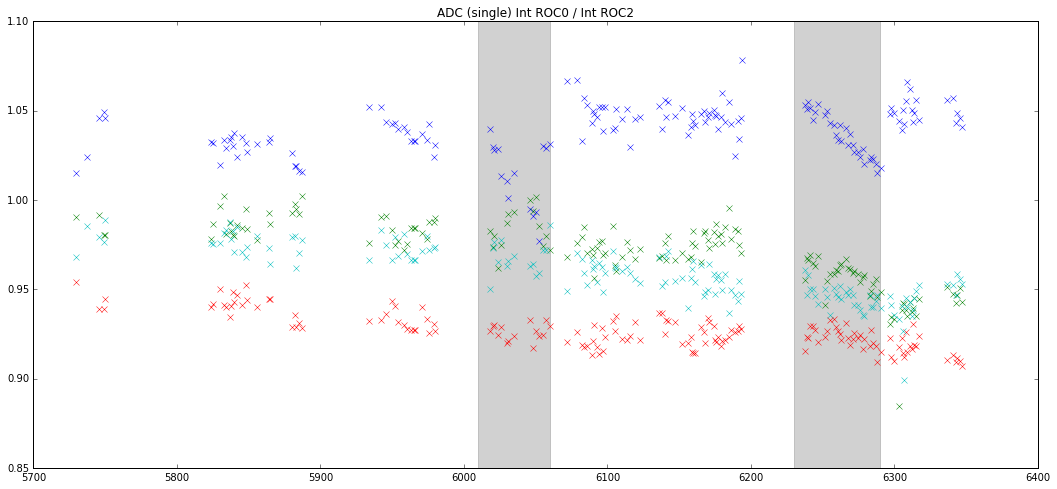

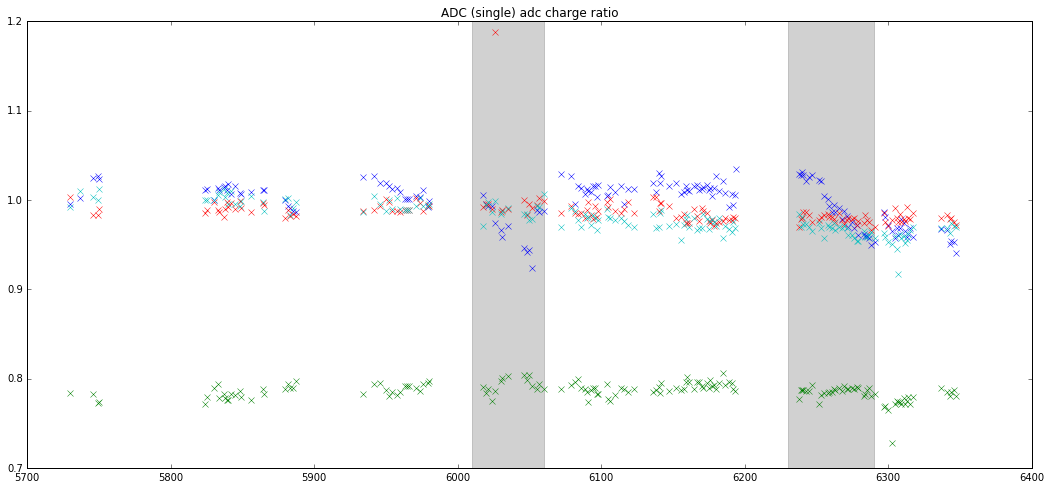

2 has been plotted using 160 points
4 has been plotted using 158 points
8 has been plotted using 158 points
10 has been plotted using 159 points
2 has been plotted using 160 points
4 has been plotted using 158 points
8 has been plotted using 158 points
10 has been plotted using 159 points


In [11]:
"""
The ratios of the integrals of the ADC spectra in ROC0 and ROC2
FOR SINGLE PIXEL
"""

Ch_list = [2, 4, 8, 10, ]#11, 13, 14, 16]

n_plot_to_fill_IDs                  = []
n_plot_to_ADC_integral_ratio        = []
n_plot_to_ADC_adc_charge_ratio      = []


for Ch in Ch_list:

    n_plot_to_fill_IDs                += [[]]
    n_plot_to_ADC_integral_ratio      += [[]]
    n_plot_to_ADC_adc_charge_ratio    += [[]]

    fill_IDs = sorted(hist_dict.keys())
    for fill_ID in fill_IDs:
        if Ch in hist_dict[fill_ID].keys():
            if 0 in hist_dict[fill_ID][Ch].keys() and 2 in hist_dict[fill_ID][Ch].keys():
                n_plot_to_fill_IDs[-1] += [fill_ID]

                hist0 = hist_dict[fill_ID][Ch][0]["h_singlePulse_ADC"].Clone()
                hist2 = hist_dict[fill_ID][Ch][2]["h_singlePulse_ADC"].Clone()
                
                #hist0 = hist_dict[fill_ID][Ch][0]["h_allPixelPulse_ADC"].Clone()
                #hist2 = hist_dict[fill_ID][Ch][2]["h_allPixelPulse_ADC"].Clone()
                
                n_plot_to_ADC_integral_ratio[-1]   += [hist0.Integral() / hist2.Integral()]
                n_plot_to_ADC_adc_charge_ratio[-1] += [hist0.GetMean()*hist0.Integral() / hist2.Integral()/hist2.GetMean()]
                
plt.figure(figsize=(18, 8))
for i in range(len(Ch_list)):

    Ch = Ch_list[i]
    
    print Ch, "has been plotted using", len(n_plot_to_fill_IDs[i]), "points"
    
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_ADC_integral_ratio[i],"x" , label= "Ch"+str(Ch)+"_ROC0/ROC2" )
    
    plt.axvspan(6010, 6060,  alpha=0.1, color='grey')
    plt.axvspan(6230, 6290,  alpha=0.1, color='grey')
    
    plt.title("ADC (single) Int ROC0 / Int ROC2")

plt.figure(figsize=(18, 8))
for i in range(len(Ch_list)):

    Ch = Ch_list[i]
    
    print Ch, "has been plotted using", len(n_plot_to_fill_IDs[i]), "points"
    
    plt.plot(n_plot_to_fill_IDs[i],  n_plot_to_ADC_adc_charge_ratio[i],"x" , label= "Ch"+str(Ch)+"_ChargeRatio" )
    
    plt.axvspan(6010, 6060,  alpha=0.1, color='grey')
    plt.axvspan(6230, 6290,  alpha=0.1, color='grey')
    
    plt.title("ADC (single) adc charge ratio")